In [5]:
import numpy as np
import pandas as pd
from collections import Counter
from math import sqrt
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data
y = iris.target
labels = iris.target_names

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [6]:
def k_means(X,K,max_iters=100,tol=1e-4,random_state = None):
    np.random.seed(random_state)
    n_samples, n_features = X.shape

    # 随机选k个点作为初始中心点
    indices = np.random.choice(n_samples, K, replace=False)
    centroids = X[indices,:].copy()

    cluster_assignments = np.zeros(n_samples,dtype=np.int32)
    for _ in range(max_iters):
        for i in range(n_samples):
            distances = [euclidean_distance(X[i],c) for c in centroids]
            # 离第i个样本最近的中心点的索引
            cluster_assignments[i] = np.argmin(distances)

        new_centroids = np.zeros((K,n_features))
        for k in range(K):
            points_in_cluster = X[cluster_assignments == k]
            if len(points_in_cluster) > 0:
                    new_centroids[k] = np.mean(points_in_cluster,axis=0)
            else:
                new_centroids[k] = X[np.random.choice(n_samples)]

        shift = np.sum(np.sqrt(np.sum((new_centroids - centroids) ** 2,axis=1)))
        if shift < tol:
            break
    return cluster_assignments,centroids

k=3
assignments,centroids = k_means(X,k,random_state=42)
print(f"K-means cluster assignments: {Counter(assignments)}")


K-means cluster assignments: Counter({0: 84, 1: 50, 2: 16})


In [7]:
def dbscan(X,eps,min_samples):
    """
    X:(n_samples,n_features)
    eps: 邻域半径
    min_samples: 成为核心点最小样本数
    """
    n_samples, n_features = X.shape
    cluster_labels = np.full(n_samples,-1,dtype=np.int32)
    visited = np.zeros(n_samples,dtype=bool)
    current_cluster = 0

    def region_query(index):
        neighbors = []
        for i in range(n_samples):
            if euclidean_distance(X[index],X[i]) < eps:
                neighbors.append(i)
        return neighbors
    
    def expand_cluster(core_index,neighbors):
        cluster_labels[core_index] = current_cluster
        for neighbor in neighbors:
            if not visited[neighbor]:
                visited[neighbor] = True
                new_neighbors = region_query(neighbor)
                if len(new_neighbors) >= min_samples:
                    neighbors.extend(new_neighbors)
            if cluster_labels[neighbor] == -1:
                cluster_labels[neighbor] = current_cluster

    for i in range(n_samples):
        if not visited[i]:
            visited[i] = True
            neighbors = region_query(i)
            if len(neighbors) < min_samples:
                cluster_labels[i] = -1
            else:    
                expand_cluster(i,neighbors)
                current_cluster += 1

    return cluster_labels

dbscan_labels = dbscan(X, eps=0.5, min_samples=5)
print("DBSCAN 聚类标签分布：", Counter(dbscan_labels))
    

DBSCAN 聚类标签分布： Counter({1: 84, 0: 49, -1: 17})


In [8]:
def cluster_accuracy(true_labels,cluster_labels):
    idx_valid = cluster_labels != -1
    if np.sum(idx_valid) == 0:
        return 0.0
    true_valid = true_labels[idx_valid]
    cluster_valid = cluster_labels[idx_valid]

    unique_labels = np.unique(cluster_valid)
    correct = 0
    for label in unique_labels:
        idx = cluster_valid == label
        if len(true_valid[idx]) == 0:
            continue
        most_common_count = Counter(true_valid[idx]).most_common(1)[0][1]
        correct += most_common_count

    return correct / len(true_labels)

def silhouette_score(X,cluster_labels):
    idx_valid = cluster_labels != -1
    X_valid = X[idx_valid]
    cluster_valid = cluster_labels[idx_valid]
    if len(X_valid) < 2:
        return 0.0
    n_samples = len(X_valid)
    unique_labels = np.unique(cluster_valid)
    cluster_dict = {}
    for label in unique_labels:
        cluster_dict[label] = np.where(cluster_valid == label)[0]

    dist_matrix = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            dist_matrix[i,j] = dist_matrix[j,i]= euclidean_distance(X_valid[i],X_valid[j])

    silhouette_scores = []
    for i in range(n_samples):
        a_i = np.mean([dist_matrix[i,j] for j in cluster_dict[cluster_valid[i]] if j != i])
        b_i = np.min([np.mean([dist_matrix[i,j] for j in cluster_dict[label]]) for label in unique_labels if label != cluster_valid[i]])
        silhouette_scores.append((b_i - a_i) / max(a_i,b_i) if max(a_i,b_i) > 0 else 0.0)

    return np.mean(silhouette_scores)


def calinski_harabasz_score(X,labels):
    index_valid = labels != -1
    X_valid = X[index_valid]
    labels_valid = labels[index_valid]
    n_samples = len(X_valid)
    unique_labels = np.unique(labels_valid)
    k = len(unique_labels)
    if k<2 or k==n_samples:
        return 0.0
    overall_mean = np.mean(X_valid,axis=0)
    ssb=0
    ssw=0

    for label in unique_labels:
        cluster_points = X_valid[labels_valid == label]
        mean_cluster = np.mean(cluster_points,axis=0)
        ssb += len(cluster_points) * np.sum(euclidean_distance(mean_cluster,overall_mean))
        ssw += np.sum([euclidean_distance(point,mean_cluster) for point in cluster_points])

    ch = (ssb / (k-1)) / (ssw / (n_samples - k))
    return ch




===== K-means 不同K的结果 =====
   K  Accuracy  Silhouette  Calinski-Harabasz
0  2  0.666667    0.686735         306.279535
1  3  0.773333    0.529627         182.687821
2  4  0.773333    0.359678         128.923359
3  5  0.840000    0.365143         111.034052

===== DBSCAN 不同 eps 的结果 (min_samples=5) =====
   eps  n_clusters  Accuracy  Silhouette  Calinski-Harabasz
0  0.3           3  0.353333    0.776834         105.127502
1  0.4           4  0.766667    0.502528         149.157570
2  0.5           2  0.620000    0.735356         327.774365
3  0.6           2  0.633333    0.722973         324.875295
4  0.7           2  0.666667    0.694110         310.480854


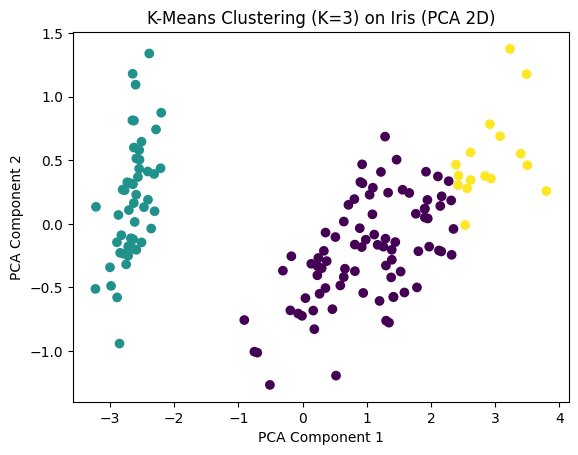

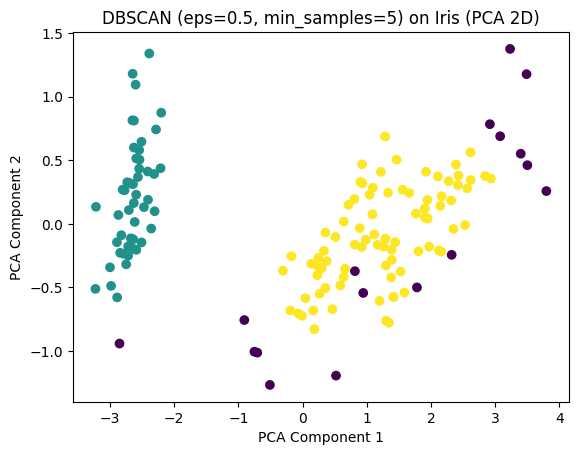

In [9]:
k_values = [2, 3, 4, 5]
results_kmeans = []

for k in k_values:
    assignments_kmeans, _ = k_means(X, K=k, random_state=42)
    acc_k = cluster_accuracy(y, assignments_kmeans)
    sil_k = silhouette_score(X, assignments_kmeans)
    ch_k = calinski_harabasz_score(X, assignments_kmeans)
    results_kmeans.append((k, acc_k, sil_k, ch_k))

df_kmeans = pd.DataFrame(results_kmeans, columns=["K", "Accuracy", "Silhouette", "Calinski-Harabasz"])
print("\n===== K-means 不同K的结果 =====")
print(df_kmeans)


eps_list = [0.3, 0.4, 0.5, 0.6, 0.7]
results_dbscan = []

for eps in eps_list:
    labels_db = dbscan(X, eps=eps, min_samples=5)
    acc_db = cluster_accuracy(y, labels_db)
    sil_db = silhouette_score(X, labels_db)
    ch_db = calinski_harabasz_score(X, labels_db)
    n_clusters = len(np.unique(labels_db[labels_db != -1]))  # 有效簇数(排除噪声-1)
    results_dbscan.append((eps, n_clusters, acc_db, sil_db, ch_db))

df_dbscan = pd.DataFrame(results_dbscan, columns=["eps", "n_clusters", "Accuracy", "Silhouette", "Calinski-Harabasz"])
print("\n===== DBSCAN 不同 eps 的结果 (min_samples=5) =====")
print(df_dbscan)



from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

assignments_k3, _ = k_means(X, K=3, random_state=42)
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=assignments_k3)
plt.title("K-Means Clustering (K=3) on Iris (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


labels_db_05 = dbscan(X, eps=0.5, min_samples=5)
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_db_05)
plt.title("DBSCAN (eps=0.5, min_samples=5) on Iris (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()